#### Required Libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import models, transforms
import matplotlib
import matplotlib.pyplot as plt
import time
import os
import copy
import random
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from torchsummary import summary

from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box, compute_ts_road_map
from modelzoo import *

#### VAE Model Summary

In [3]:
model = vae()
inp = torch.rand([3,6,3,256,306])
model.summarize(inp)

Class: vae
Passed Input Size:torch.Size([3, 6, 3, 256, 306])
----
     Class: encoder
     resnet_style: 18, pretrained: False
     Passed Input Size:torch.Size([3, 3, 256, 306])
     Output Size:torch.Size([3, 512, 8, 8])
----
Number of encoded states: 6, each of size: torch.Size([3, 512, 8, 8])
Concatenated encoded states shape: torch.Size([3, 3072, 8, 8])
----
     Class: encoder_after_resnet
     Passed Input Size:torch.Size([3, 3072, 8, 8])
     Convolved Encoded state shape: torch.Size([3, 512, 4, 4])
     Output Mean Size:torch.Size([3, 4096])
     Output Var Size:torch.Size([3, 4096])
----
Output Mean Size:torch.Size([3, 4096])
Output Var Size:torch.Size([3, 4096])
Reparameterized Hidden State size: torch.Size([3, 4096])
----
     Class: vae_decoder
     Passed Input Size:torch.Size([3, 4096])
     Input recast into shape: torch.Size([3, 64, 8, 8])
     Output Size:torch.Size([3, 800, 800])
----
Output Size:torch.Size([3, 800, 800])


#### AE Model Summary

In [4]:
model = autoencoder()
inp = torch.rand([3,6,3,256,306])
model.summarize(inp)

Class: autoencoder
Passed Input Size:torch.Size([3, 6, 3, 256, 306])
----
     Class: encoder
     resnet_style: 18, pretrained: False
     Passed Input Size:torch.Size([3, 3, 256, 306])
     Output Size:torch.Size([3, 512, 8, 8])
----
Number of encoded states: 6, each of size: torch.Size([3, 512, 8, 8])
Concatenated Hidden State size: torch.Size([3, 3072, 8, 8])
----
     Class: decoder
     Passed Input Size:torch.Size([3, 3072, 8, 8])
     Output Size:torch.Size([3, 800, 800])
----
Output Size:torch.Size([3, 800, 800])


### Setting project details

In [5]:
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

seed = 8964
torch.backends.cudnn.benchmark = True
# torch.backends.cudnn.deterministic = True
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)


image_folder = '../data'
annotation_csv = '../data/annotation.csv'

labeled_scene_index = np.arange(106, 134)

start_index = 106
end_index = 134

n_train_samples = 24
n_val_samples = 3
n_test_samples = 1

assert n_train_samples + n_val_samples + n_test_samples == 28 #No of labeled samples

train_labeled_scene_index = np.arange(start_index, start_index+n_train_samples)
val_labeled_scene_index = np.arange(start_index+n_train_samples,start_index+n_train_samples+n_val_samples)
test_labeled_scene_index = np.arange(start_index+n_train_samples+n_val_samples, end_index)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

transform = torchvision.transforms.ToTensor()

train_labeled_set = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=train_labeled_scene_index,
                                  transform=transform,
                                  extra_info=True
                                 )

val_labeled_set = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=val_labeled_scene_index,
                                  transform=transform,
                                  extra_info=True
                                 )

test_labeled_set = LabeledDataset(image_folder=image_folder,
                                  annotation_file=annotation_csv,
                                  scene_index=test_labeled_scene_index,
                                  transform=transform,
                                  extra_info=True
                                 )

# train_val_split_ratio = 0.85
# n=len(train_labeled_set)
# n_train=int(train_val_split_ratio*n)+1
# n_val=int((1-train_val_split_ratio)*n)
# assert n_train+n_val==n
#train_set, val_set = torch.utils.data.random_split(train_labeled_set, [n_train, n_val])

In [6]:
def prepare_experiment(model_tag, 
                       batch_size = 16, 
                       resnet_style = '18', 
                       weights ='random', 
                       model_type ='ae', 
                       checkpoint_folder = '/scratch/kae358/Deep/Deep_Learning/ssl_project/checkpoints'):

    train_loader = torch.utils.data.DataLoader(train_labeled_set, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=collate_fn)
    val_loader = torch.utils.data.DataLoader(val_labeled_set, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=collate_fn)
    test_loader = torch.utils.data.DataLoader(test_labeled_set, batch_size=1, shuffle=True, num_workers=4, collate_fn=collate_fn)

    dataloaders = {'train': train_loader, 'val': val_loader, 'test': test_loader}

    if weights == 'random':
        pretrained = False
    elif weights == 'imagenet':
        pretrained = True
    elif weights == 'ssl':
        pretrained = False

    print('Model Type: {0}'.format(model_type))

    if model_type == 'ae':
        model = autoencoder(resnet_style=resnet_style, pretrained=pretrained)
    elif model_type == 'vae':
        model = vae(resnet_style=resnet_style, pretrained=pretrained)

    sample_input = torch.rand([3,6,3,256,306])
    print('{} Model Summary'.format(model_type))
    model.summarize(sample_input)

    model = model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=0.0001)
    scheduler = lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.97)
    criterion = nn.BCELoss()

    today = datetime.now().date()
    
    checkpoint_tag = '{0}-{1}{2}'.format(today.day,today.month, model_tag)
    checkpoint_path = checkpoint_folder + 'checkpoint_{0}.pth.tar'.format(checkpoint_tag)
    best_checkpoint_path = checkpoint_folder + 'checkpoint_{0}_best.pth.tar'.format(checkpoint_tag)

    return model, optimizer, scheduler, criterion, dataloaders, checkpoint_path, best_checkpoint_path

#### Training and Validation

In [7]:
def train(num_epochs, model, model_type, model_tag, optimizer, scheduler, criterion, restore, threshold, dataloaders, checkpoint_path, best_checkpoint_path, tensorboard_log_dir):

    if restore:
        print('Checking to restore...')
        if os.path.isfile(checkpoint_path):
            print('Restoring checkpoint from {}'.format(checkpoint_path))
            state = torch.load(checkpoint_path)
            epoch = state['epoch']
            best_loss = state['best_loss']
            best_ts = state['best_ts']
            model.load_state_dict(state['state_dict'])
            optimizer.load_state_dict(state['optimizer'])
            scheduler.load_state_dict(state['scheduler'])
        else:
            print('No checkpoint found at {}'.format(checkpoint_path))
            epoch = 0
            best_loss = np.inf
            best_ts = 0
    else:
        print('Not checking to restore')
        epoch = 0
        best_loss = np.inf
        best_ts = 0
            
    writer = SummaryWriter(log_dir=tensorboard_log_dir, comment=model_tag)

    while epoch < num_epochs:
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            threat_score = 0.0

            # Iterate over data.
            for i, temp_batch in tqdm(enumerate(dataloaders[phase])):
                samples, targets, tar_sems, road_images, extras  = temp_batch
                samples = torch.stack(samples).to(device)
                road_images = torch.stack(road_images).to(device)
                tar_sems = torch.stack(tar_sems).to(device)
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    if model_type == 'ae':
                        pred_maps = model(samples)
                        loss = criterion(pred_maps, tar_sems.float())
                    elif model_type == 'vae':
                        pred_maps, mu, logvar = model(samples,phase == 'train')
                        loss, CE, KLD = loss_function(pred_maps, tar_sems, mu, logvar)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                    else:
                        for pred_map,tar_sem in zip(pred_maps,tar_sems):
                            ts_road_map = compute_ts_road_map(pred_map > threshold, pred_map)
                            threat_score += ts_road_map

                running_loss += loss.item()#*batch_size

                # tensorboard logging
                if phase == 'train':
                    writer.add_scalar(phase+'_loss', loss.item(), epoch * len(train_labeled_set) / dataloaders[phase].batch_size + i)
                    if model_type == 'vae':
                        writer.add_scalar(phase+'_loss_CE', CE.item(), epoch * len(train_labeled_set) / dataloaders[phase].batch_size + i)
                        writer.add_scalar(phase+'_loss_KLD', KLD.item(), epoch * len(train_labeled_set) / dataloaders[phase].batch_size + i)

                # statistics
            if phase == 'train':
                running_loss = running_loss / len(train_labeled_set) # per batch, per sample
                print(phase, 'running_loss:', round(running_loss,4))
                writer.add_scalar(phase+'_total_loss', running_loss, epoch)
            else:
                running_loss = running_loss / len(val_labeled_set)
                print(phase,'running_loss:', round(running_loss,4), 'cumulative_threat_score:', round(threat_score.item(),4), \
                      'val_len:',len(val_labeled_set), '\n mean_threat_score:',round(threat_score.item() / len(val_labeled_set),4))#, iou / len(val_set))
                writer.add_scalar(phase+'_ts', threat_score.item()/len(val_labeled_set), epoch)
                writer.add_scalar(phase+'_total_loss', running_loss, epoch)

        # Saving best loss model so far
        if running_loss < best_loss:
            best_loss = running_loss
            torch.save({
                'epoch': epoch + 1,
                'state_dict': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'scheduler': scheduler.state_dict(),
                'best_loss': best_loss,
                'best_ts': best_ts
                }, best_checkpoint_path)
            print('best_loss model after %d epoch saved...' % (epoch+1))

        # Saving best ts model so far
        #if threat_score > best_ts:
        #    best_ts = threat_score
        #    torch.save({
        #        'epoch': epoch + 1,
        #        'state_dict': model.state_dict(),
        #        'optimizer': optimizer.state_dict(),
        #        'scheduler': scheduler.state_dict(),
        #        'best_loss': best_loss,
        #        'best_ts': best_ts
        #        }, best_checkpoint_path)
        #    print('best_ts model after %d epoch saved...' % (epoch+1))

        # save model per epoch
        torch.save({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
            'best_loss': best_loss,
            'best_ts': best_ts
            }, checkpoint_path)
        print('model after %d epoch saved...' % (epoch+1))
        epoch += 1

    writer.close()

### Running Experiment

In [8]:
checkpoint_folder = '/scratch/kae358/Deep/Deep_Learning/checkpoints/'
tensorboard_log_dir = '/scratch/kae358/Deep/Deep_Learning/runs/'


batch_size = 8
resnet_style = '18'
weights = 'random'
model_type ='vae'
num_epochs = 25
threshold = 0.5
restore = False #Restore from checkpoint, if checkpoint exists

model_tag = '_Batch:{}_Model:{}'.format(batch_size,model_type+resnet_style+weights)
print('model_tag:{}'.format(model_tag))
    
parameters = prepare_experiment(model_tag = model_tag, batch_size = batch_size, resnet_style = resnet_style, weights = weights, model_type = model_type, checkpoint_folder = checkpoint_folder)

model, optimizer, scheduler, criterion, dataloaders, checkpoint_path, best_checkpoint_path = parameters   


#train(num_epochs, model, model_type, model_tag, optimizer, scheduler,  criterion, restore, threshold, dataloaders, checkpoint_path, best_checkpoint_path, tensorboard_log_dir)

model_tag:_Batch:8_Model:vae18random
Model Type: vae
vae Model Summary
Class: vae
Passed Input Size:torch.Size([3, 6, 3, 256, 306])
----
     Class: encoder
     resnet_style: 18, pretrained: False
     Passed Input Size:torch.Size([3, 3, 256, 306])
     Output Size:torch.Size([3, 512, 8, 8])
----
Number of encoded states: 6, each of size: torch.Size([3, 512, 8, 8])
Concatenated encoded states shape: torch.Size([3, 3072, 8, 8])
----
     Class: encoder_after_resnet
     Passed Input Size:torch.Size([3, 3072, 8, 8])
     Convolved Encoded state shape: torch.Size([3, 512, 4, 4])
     Output Mean Size:torch.Size([3, 4096])
     Output Var Size:torch.Size([3, 4096])
----
Output Mean Size:torch.Size([3, 4096])
Output Var Size:torch.Size([3, 4096])
Reparameterized Hidden State size: torch.Size([3, 4096])
----
     Class: vae_decoder
     Passed Input Size:torch.Size([3, 4096])
     Input recast into shape: torch.Size([3, 64, 8, 8])
     Output Size:torch.Size([3, 800, 800])
----
Output Size:

In [20]:
import sys
sys.path.append("..")
import utils
%load_ext autoreload
%autoreload 2

### Evaluation & Analysis

In [21]:
def evaluate(model, model_type, model_path, dataloaders, phase, display_images = False, n_batch_to_display = 3, threshold = 0.5):
    
    assert phase != 'unlabeled'
    
    print('Estimating performance on {} set'.format(phase))
    print('Restoring Best checkpoint from {}'.format(model_path))
    state = torch.load(model_path)
    epoch = state['epoch']
    model.load_state_dict(state['state_dict'])
    
    model.eval()

    threat_score = 0.0
    total = 0.0
    
    for i, temp_batch in enumerate(dataloaders[phase]):
        if display_images and i == n_batch_to_display:
            break
        total += len(temp_batch[0])
        samples, targets, tar_sems, road_images, extra = temp_batch
        samples = torch.stack(samples).to(device)
        road_images = torch.stack(road_images).to(device)
        tar_sems = torch.stack(tar_sems).to(device)
        if model_type == 'ae':
            pred_maps = model(samples)
        elif model_type == 'vae':
            pred_maps, mu, logvar = model(samples,is_training=False)

        for pred_map,tar_sem, target in zip(pred_maps,tar_sems, targets):
            bb_pred = utils.get_bounding_boxes_from_seg(pred_map > threshold, 10, 800, 800)
            ts_road_map = utils.compute_ats_bounding_boxes(bb_pred, target["bounding_box"])
            threat_score += ts_road_map

        if display_images:
            for sample,pred_map,tar_sem in zip(samples,pred_maps,tar_sems):
                print('Test Batch: {}'.format(i))
                # CAM_FRONT_LEFT, CAM_FRONT, CAM_FRONT_RIGHT, CAM_BACK_LEFT, CAM_BACK, CAM_BACK_RIGHT
                plt.imshow(torchvision.utils.make_grid(sample.detach().cpu(), nrow=3).numpy().transpose(1, 2, 0))
                fig, (ax1, ax2) = plt.subplots(1, 2)
                fig.suptitle('Road Map Comparison')
                ax1.imshow(tar_sem.detach().cpu(), cmap='binary');
                ax1.set_title('Original Road Map')
                ax2.imshow((pred_map > threshold).detach().cpu(), cmap='binary');
                ax2.set_title('Predicted Road Map')
                plt.show()
                print('-'*20)

    threat_score /= total
    print('Total samples: {}, Total Threat Score: {}'.format(total,total*threat_score))
    print('Mean Threat Score is: {}'.format(threat_score))

### Verifying Performance on Test (Val & Train) set

In [43]:
evaluate(model, model_type, checkpoint_path, dataloaders,  'val', display_images = False , n_batch_to_display = 10, threshold = 0.5)
# evaluate(model, model_type, best_checkpoint_path, dataloaders,  'val', display_images = True , n_batch_to_display = 1, threshold = 0.5)
# evaluate(model, model_type, best_checkpoint_path, dataloaders,  'train', display_images = True , n_batch_to_display = 1, threshold = 0.5)

Estimating performance on val set
Restoring Best checkpoint from /scratch/kae358/Deep/Deep_Learning/checkpoints/checkpoint_27-4_Batch:8_Model:vae18random.pth.tar
Total samples: 378.0, Total Threat Score: 0.9960983991622925
Mean Threat Score is: 0.002635180950164795


In [45]:
sys.path.append("../..")

In [46]:
from preprocessing.top_down_segmentation import create_data

In [ ]:
create_data()

### Measure performance of all models trained so far

In [85]:
# trained_best_models_list = ['ae_checkpoint25-4-res50-random_best.pth.tar'
# ,'ae_checkpoint4-24-res18-random_best.pth.tar'
# ,'ae_checkpoint_6img_132_p100_best.pth.tar'
# ,'checkpoint_25-4_Batch:8_Model:ae18random_best.pth.tar'
# ,'vae_checkpoint25-4-res18-random_best.pth.tar'
# ,'vae_checkpoint25-4-res50-random_best.pth.tar'
# ,'vae_checkpoint_6img_132_p100_best.pth.tar'
# ,'vae_checkpoint_random_132_p100_best.pth.tar',
# 'checkpoint_25-4_Batch:16_Model:vae18random_best.pth.tar']

# path_to_checkpoints = '/home/sc6957/dlproject/code/checkpoints/'

In [ ]:
current_checkpoint_folder = '/scratch/sc6957/dlproject/checkpoints/'
old_checkpoint_folder = '/scratch/sc6957/dlproject/old_checkpoints/'

current_trained_best_models_list = ['ae_checkpoint25-4-res50-random_best.pth.tar'
,'ae_checkpoint4-24-res18-random_best.pth.tar'
,'ae_checkpoint_6img_132_p100_best.pth.tar'
,'checkpoint_25-4_Batch:8_Model:ae18random_best.pth.tar'
,'vae_checkpoint25-4-res18-random_best.pth.tar'
,'vae_checkpoint25-4-res50-random_best.pth.tar'
,'vae_checkpoint_6img_132_p100_best.pth.tar'
,'vae_checkpoint_random_132_p100_best.pth.tar',
'checkpoint_25-4_Batch:16_Model:vae18random_best.pth.tar']

old_trained_best_models_list = ['ae_checkpoint25-4-res50-random_best.pth.tar'
,'ae_checkpoint4-24-res18-random_best.pth.tar'
,'ae_checkpoint_6img_132_p100_best.pth.tar'
,'checkpoint_25-4_Batch:8_Model:ae18random_best.pth.tar'
,'vae_checkpoint25-4-res18-random_best.pth.tar'
,'vae_checkpoint25-4-res50-random_best.pth.tar'
,'vae_checkpoint_6img_132_p100_best.pth.tar'
,'vae_checkpoint_random_132_p100_best.pth.tar',
'checkpoint_25-4_Batch:16_Model:vae18random_best.pth.tar']

trained_best_models_list = old_trained_best_models_list
path_to_checkpoints = old_checkpoint_folder

start_ind = 0
end_ind = len(old_trained_best_models_list)

In [86]:
for name in trained_best_models_list[start_ind:end_ind]:
    current_model_path = path_to_checkpoints + name
    
    resnet_style = '18'
    if '50' in current_model_path:
        resnet_style = '50'
    
    model_type = 'ae'
    if 'vae' in current_model_path:
        model_type = 'vae'
    
    print(current_model_path)
    print('Creating model with Resnet Style: {0}, Model Type: {1}'.format(resnet_style,model_type))

    if model_type == 'ae':
        model = autoencoder(resnet_style=resnet_style,pretrained=False)
    elif model_type == 'vae':
        model = vae(resnet_style=resnet_style,pretrained=False)
    
    model = model.to(device)
    print('-------')
    evaluate(model, model_type, current_model_path, dataloaders,  'test', display_images = False)
    evaluate(model, model_type, current_model_path, dataloaders,  'val', display_images = False)
    print('-------'*4)

/home/sc6957/dlproject/code/checkpoints/vae_checkpoint25-4-res18-random_best.pth.tar
Creating model with Resnet Style: 18, Model Type: vae
-------
Estimating performance on test set
Restoring Best checkpoint from /home/sc6957/dlproject/code/checkpoints/vae_checkpoint25-4-res18-random_best.pth.tar
Total samples: 252.0, Total Threat Score: 219.46495056152344
Mean Threat Score is: 0.8708926439285278
Estimating performance on val set
Restoring Best checkpoint from /home/sc6957/dlproject/code/checkpoints/vae_checkpoint25-4-res18-random_best.pth.tar
Total samples: 491.0, Total Threat Score: 462.19647216796875
Mean Threat Score is: 0.941336989402771
----------------------------


### Unlabeled testing

In [49]:
unlabeled_scene_index = np.arange(106)
#test_unlabeled_scene_index = np.arange(1,3)

unlabeled_set = UnlabeledDataset(image_folder=image_folder, scene_index=unlabeled_scene_index, first_dim='sample', transform=transform)
unlabeled_loader = torch.utils.data.DataLoader(unlabeled_set, batch_size=3, shuffle=True, num_workers=4)
dataloaders.update({'unlabeled':unlabeled_loader})

In [50]:
def evaluate_unlabeled(model, model_type, model_path, phase, display_images = False, n_batch_to_display = 3, threshold = 0.5):
    assert phase == 'unlabeled'
    print('Estimating performance on {} set'.format(phase))
    print('Restoring Best checkpoint from {}'.format(model_path))
    state = torch.load(model_path)
    epoch = state['epoch']
    model.load_state_dict(state['state_dict'])
    
    model.eval()

    total = 0.0
    for i, temp_batch in enumerate(dataloaders[phase]):
        if display_images and i == n_batch_to_display:
            break
        total += len(temp_batch)
        samples = temp_batch.to(device)
        if model_type == 'ae':
            pred_maps = model(samples)
        elif model_type == 'vae':
            pred_maps, mu, logvar = model(samples,is_training=False)


        if display_images:
            print('Test Batch: {}'.format(i))
            for sample,pred_map in zip(samples,pred_maps):
                # CAM_FRONT_LEFT, CAM_FRONT, CAM_FRONT_RIGHT, CAM_BACK_LEFT, CAM_BACK, CAM_BACK_RIGHT
                plt.imshow(torchvision.utils.make_grid(sample.detach().cpu(), nrow=3).numpy().transpose(1, 2, 0))
                fig, ax = plt.subplots(1, 1)
                ax.imshow((pred_map > threshold).detach().cpu(), cmap='binary');
                ax.set_title('Predicted Road Map')
                plt.show()
                print('-'*20)
                
    print('Total samples: {}'.format(total))

In [53]:
best_checkpoint_path

'/scratch/sc6957/dlproject/checkpoints/checkpoint_26-4_Batch:16_Model:ae18random_best.pth.tar'

Estimating performance on unlabeled set
Restoring Best checkpoint from /scratch/sc6957/dlproject/checkpoints/checkpoint_26-4_Batch:16_Model:ae18random_best.pth.tar
Test Batch: 0


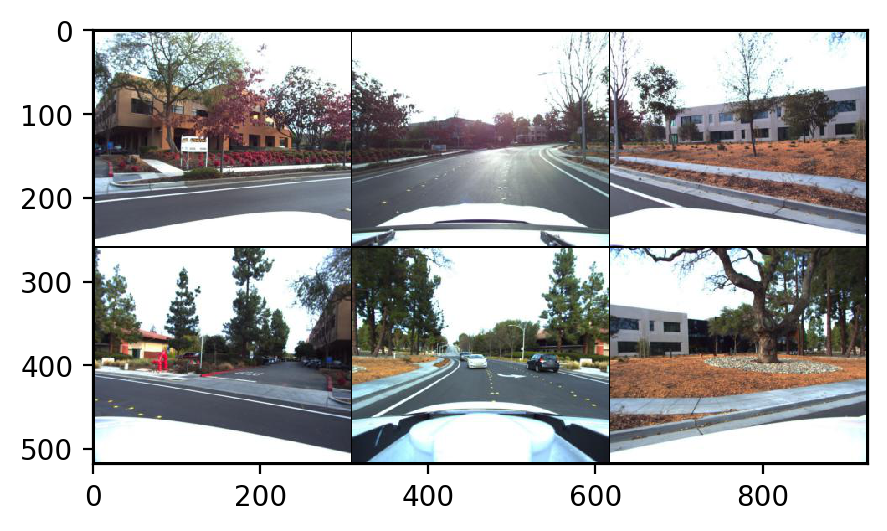

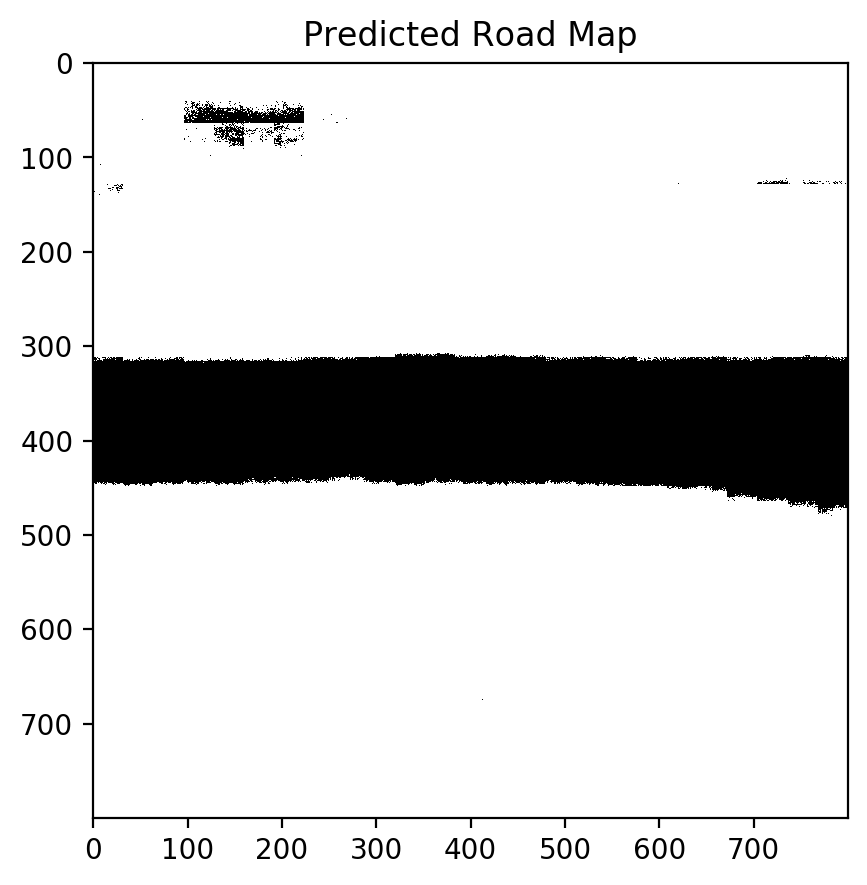

--------------------


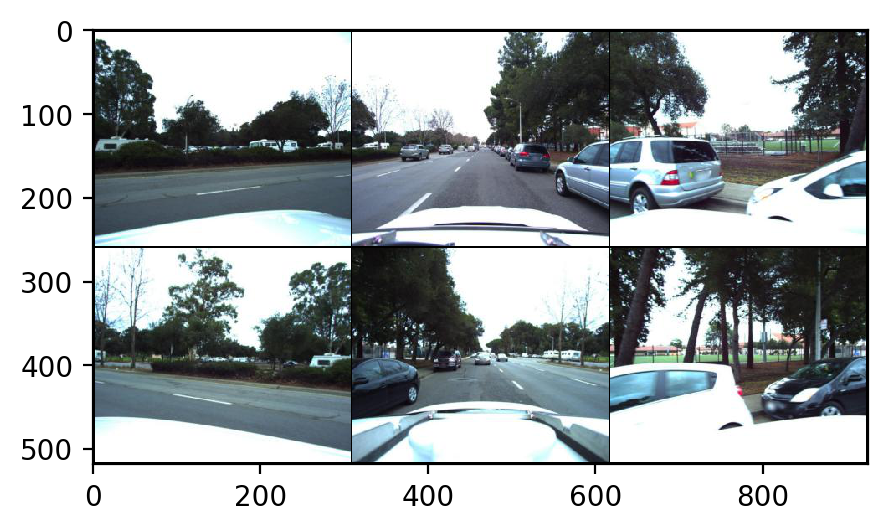

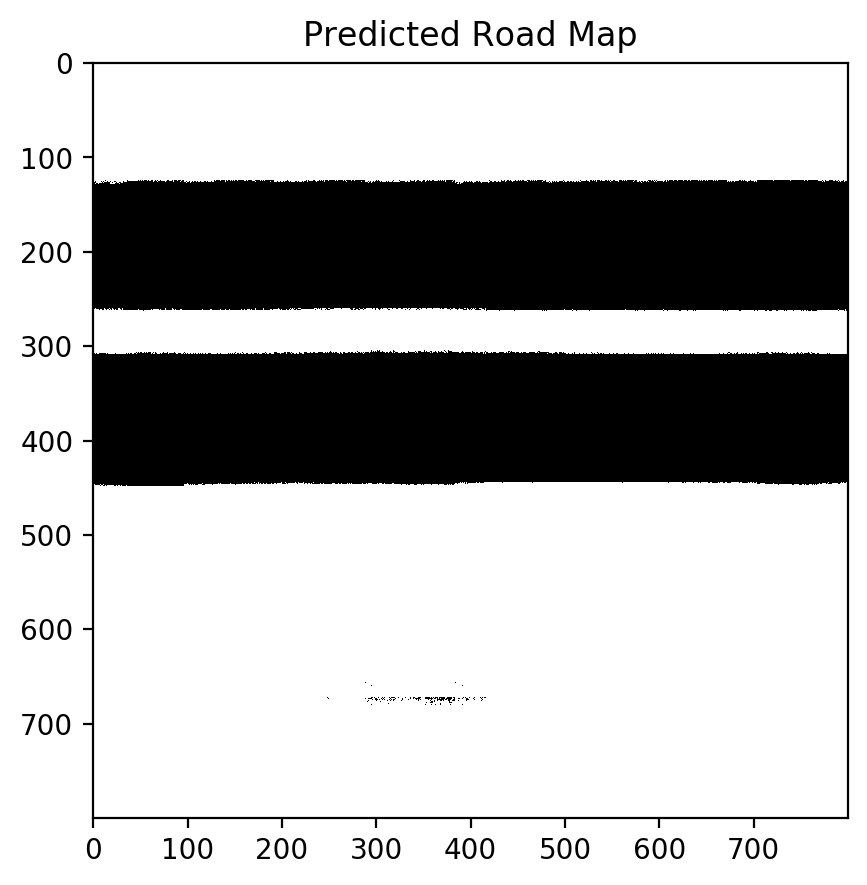

--------------------


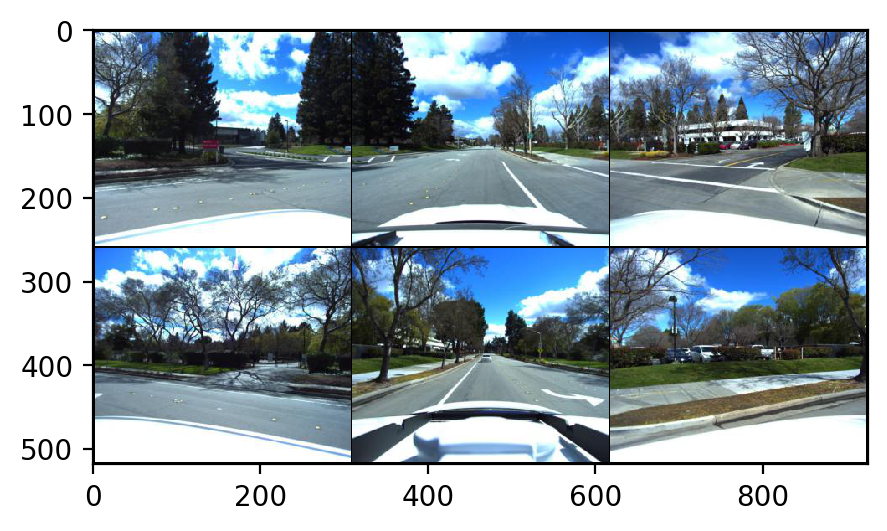

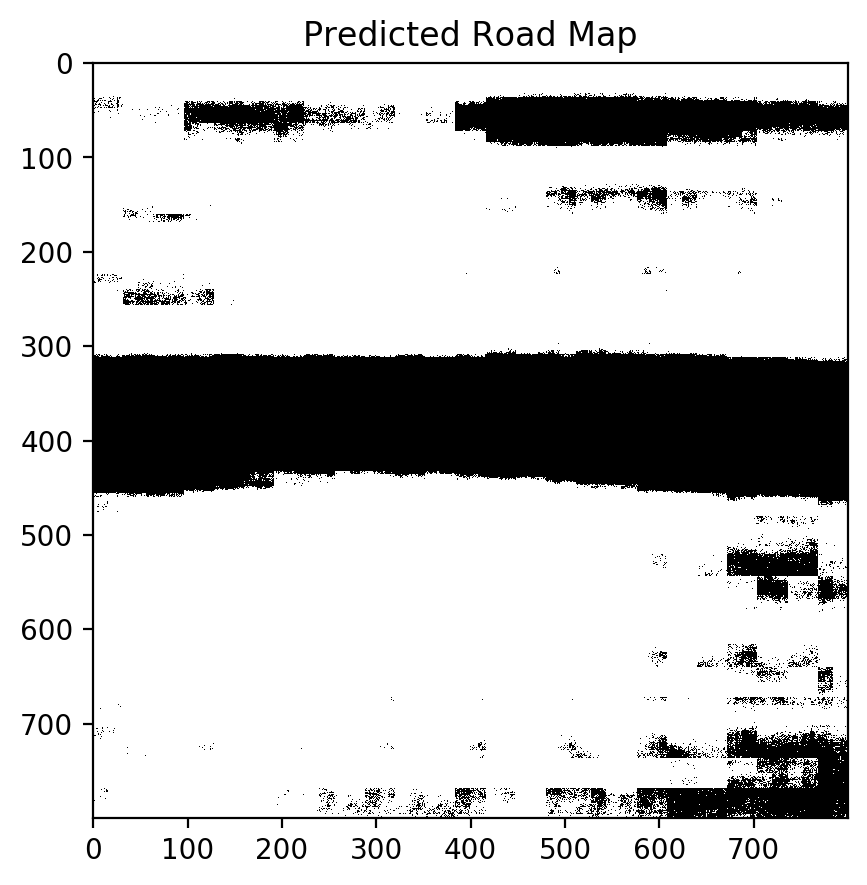

--------------------
Total samples: 3.0


In [54]:
evaluate_unlabeled(model, model_type, best_checkpoint_path, 'unlabeled', \
                   display_images = True , n_batch_to_display = 1, threshold = 0.4)